In [1]:
from qiskit import Aer, QuantumCircuit
from qiskit.circuit import Parameter, ParameterVector
from qiskit.opflow import StateFn, PauliSumOp, AerPauliExpectation, ListOp, Gradient, OperatorStateFn
from qiskit.utils import QuantumInstance
import matplotlib.pyplot as plt
from qiskit_utils import BinaryObjectiveFunction
from data_utils import circle, plot_data, generate_ds
import numpy as np
# Set a random seed
np.random.seed(42)

In [2]:
# Generate training and test data
num_training = 200
num_test = 2000

X_train, y_train, new_y_train = generate_ds(num_training)
X_test, y_test, new_y_test= generate_ds(num_test)

In [3]:
# set method to calculcate expected values
expval = AerPauliExpectation()

# define gradient method
gradient = Gradient()

# define quantum instances (statevector and sample based)
qi_sv = QuantumInstance(Aer.get_backend('aer_simulator_statevector'))

In [4]:
from qiskit_machine_learning.neural_networks import OpflowQNN

inputs = ParameterVector('input', length=4) # 1 extra for label
weights = ParameterVector('weight', length=15)

# 1qubit classifier
qc1 = QuantumCircuit(1)
qc1.h(0)
qc1.rz(inputs[0]*weights[0]+inputs[1]*weights[1]+inputs[2]*weights[2] + weights[3],0)
qc1.ry(weights[4],0)
qc1.rz(inputs[0]*weights[5]+inputs[1]*weights[6]+inputs[2]*weights[7] + weights[8],0)
qc1.ry(weights[9],0)
qc1.rz(inputs[0]*weights[10]+inputs[1]*weights[11]+inputs[2]*weights[12] + weights[13],0)
qc1.ry(weights[14],0)
qc_sfn1 = StateFn(qc1)

H1 = StateFn(PauliSumOp.from_list([('Z', 1.0)]))  
H2 = StateFn(PauliSumOp.from_list([('Z', -1.0)]))  

op1 = ~H1 @ (qc_sfn1)
op2 = ~H2 @ (qc_sfn1)
print(op1)
print(len(weights))

ComposedOp([
  OperatorMeasurement(1.0 * Z),
  CircuitStateFn(
       ┌───┐»
  q_0: ┤ H ├»
       └───┘»
  «     ┌──────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ Rz(input[0]*weight[0] + input[1]*weight[1] + input[2]*weight[2] + weight[3]) ├»
  «     └──────────────────────────────────────────────────────────────────────────────┘»
  «     ┌───────────────┐»
  «q_0: ┤ Ry(weight[4]) ├»
  «     └───────────────┘»
  «     ┌──────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ Rz(input[0]*weight[5] + input[1]*weight[6] + input[2]*weight[7] + weight[8]) ├»
  «     └──────────────────────────────────────────────────────────────────────────────┘»
  «     ┌───────────────┐»
  «q_0: ┤ Ry(weight[9]) ├»
  «     └───────────────┘»
  «     ┌──────────────────────────────────────────────────────────────────────────────────┐»
  «q_0: ┤ Rz(input[0]*weight[10] + input[1]*weight[11] + input[2]*weight[12] + weight[13]) ├»
  «  

In [5]:
# construct OpflowQNN with the operator, the input parameters, the weight parameters,
# the expected value, gradient, and quantum instance.
qnn1 = OpflowQNN(op1, inputs, weights, expval, gradient, qi_sv, input_gradients=True)
qnn2 = OpflowQNN(op2, inputs, weights, expval, gradient, qi_sv, input_gradients=True)

In [6]:
from qiskit.algorithms.optimizers import ADAM, L_BFGS_B
from qiskit_machine_learning.utils.loss_functions import L2Loss

losses = []
def callback_fn(avg_loss, weights):
    print("weights: ", weights)
    print("loss: ", avg_loss)
    losses.append(avg_loss)

function = BinaryObjectiveFunction(X_train, new_y_train, qnn1, qnn2, L2Loss(), callback_fn)

In [20]:
losses = []
# optimizer = ADAM(maxiter=30, lr=0.8)
optimizer = L_BFGS_B(maxiter=50)
# fit_result = optimizer.minimize(
fit_result = optimizer.optimize(
    num_vars=qnn1.num_weights,
    objective_function=function.objective,
    initial_point=algorithm_globals.random.random(qnn1.num_weights),
    gradient_function=function.gradient,
)

<bound method BinaryObjectiveFunction.gradient of <__main__.BinaryObjectiveFunction object at 0x000001B01ADBBDF0>>
weights:  [0.61967214 0.76124048 0.72273381 0.44505305 0.85633522 0.25035778
 0.50836627 0.61321615 0.98824612 0.13774056 0.93155019 0.31188414
 0.56115245 0.27922738 0.41286729]
loss:  1.2300306639330179
weights:  [0.41826128 0.68681352 0.72273381 1.05776863 0.50461904 0.27057227
 0.56627172 0.61321615 1.44022728 0.23491431 0.97324184 0.36536509
 0.56115245 0.6378582  0.73545651]
loss:  0.9224804593177606
weights:  [4.06111167e-01 7.31145892e-01 7.22733806e-01 1.04839935e+00
 5.48753767e-01 3.53376239e-01 6.44319226e-01 6.13216153e-01
 1.57093001e+00 1.26693517e-03 1.07587690e+00 3.99549622e-01
 5.61152449e-01 7.75216227e-01 6.30390269e-01]
loss:  0.8481785113427937
weights:  [0.41880448 0.71517043 0.72273381 0.96208006 0.59131908 0.35078524
 0.61748205 0.61321615 1.49897836 0.02779754 1.07058059 0.37533193
 0.56115245 0.71021428 0.61284474]
loss:  0.8399930384574017
weig

weights:  [ 0.16854773  0.43800574  0.72273381  0.52933211  0.43296753  0.9814838
  0.38607224  0.61321615  1.64743448  0.33577898  1.86197961 -0.94115513
  0.56115245  0.90644946  1.2060829 ]
loss:  0.539618308717522
weights:  [ 0.15965257  0.67727602  0.72273381  0.52623246  0.53082747  0.98907176
  0.46531036  0.61321615  1.61636168  0.54245372  1.88605249 -1.35413982
  0.56115245  0.9527607   1.00352325]
loss:  0.5427214153457492
weights:  [ 0.1654964   0.52008343  0.72273381  0.52826883  0.46653675  0.98408672
  0.41325356  0.61321615  1.63677547  0.40667531  1.87023741 -1.08282265
  0.56115245  0.92233576  1.13659819]
loss:  0.5387700353881545
weights:  [ 0.15983246  0.66179478  0.72273381  0.53532727  0.48286194  0.99146975
  0.45767645  0.61321615  1.62071576  0.53136038  1.88961143 -1.3257092
  0.56115245  0.9409202   1.02254491]
loss:  0.5366270948588407
weights:  [ 0.14633093  0.72810941  0.72273381  0.54425591  0.40472341  0.99532186
  0.47807048  0.61321615  1.61420054  0.

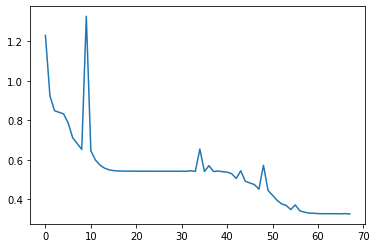

In [21]:
plt.plot(losses)

In [7]:
ws = [-1.0777535 ,  2.55307983,  0.72273381,  0.50429528, -0.25476697,
        0.74738858,  0.42312372,  0.61321615,  2.42012697,  0.94091601,
        3.51580432, -2.55687703,  0.56115245,  0.27013635,  0.94440804]

from test_utils import get_metrics
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_train, qnn1, ws)

Accuracy:  0.89
tp:  87 tn:  91  fp:  12  fn:  10


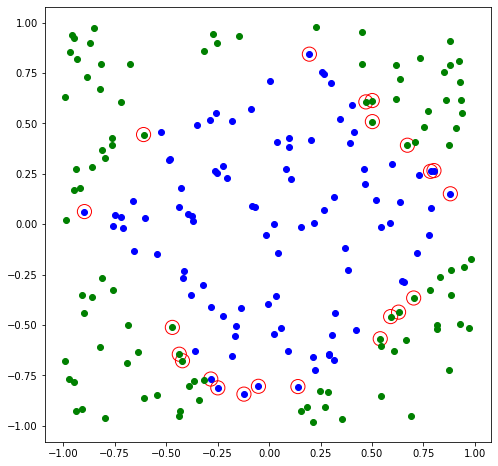

In [8]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_train, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()

In [10]:
y_predict, y_tensor, accuracy, [tp, tn, fp, fn] = get_metrics(X_test, qnn1, ws)

Accuracy:  0.8775
tp:  891 tn:  864  fp:  112  fn:  133


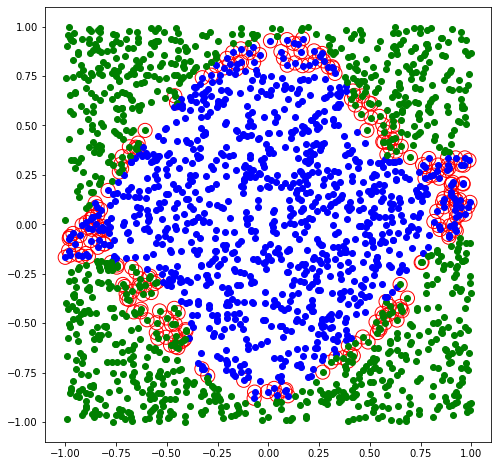

In [11]:
# print('Accuracy:', acc/len(y_tensor))
plt.figure(figsize=(8,8))
for x, y_target, y_ in zip(X_test, y_tensor, y_predict):
    if y_ == 1:
        plt.plot(x[0], x[1], 'bo')
    else:
        plt.plot(x[0], x[1], 'go')
    if y_target != y_:
        plt.scatter(x[0], x[1], s=200, facecolors='none', edgecolors='r', linewidths=1)
plt.show()